# Detecting objects in your images using the mobilenet Pipeline 

The following tutorial shows you 

1. How to deploy a wallaroo pipeline using faster rcnn mobilenet model created in step 2
2. Then run inference on a sample image
3. Draw the detected objects, their bounding boxes, their classifications, and the confidence of the classifications on the provided image.
4. Review our results



In [1]:
import torch
import pickle
import wallaroo
import os
import numpy as np
import json
import requests
import time
import pandas as pd
from CVDemoUtils import CVDemo


In [2]:
wl = wallaroo.Client()

In [3]:
model_name = 'resnet50'
model = wl.upload_model(model_name, "models/frcnn-resnet.pt.onnx")

Next we will add our post processing anomoly detection file called post-process-anomoly-detection.py.  Predictions that are lower than 75% we will consider anomalies that need to be inspected.

In [4]:
deployment_config = wallaroo.DeploymentConfigBuilder().replica_count(2).cpus(1).memory("12Gi").build()

In [5]:
pipeline_name = 'resnet50-pp'
pipeline = wl.build_pipeline(pipeline_name) \
            .add_model_step(model)

pipeline.deploy(deployment_config = deployment_config)

Waiting for deployment - this will take up to 45s ...... ok


name,resnet50-pp
created,2022-11-04 13:30:39.844788+00:00
last_updated,2022-12-14 12:57:22.088192+00:00
deployed,True
tags,
steps,mobilenet


In [6]:
time.sleep(5) # needed to allow the pipeline to settle in.

## Test the pipeline by running inference on a sample image

### Prepare input image

Next we will load a sample image and resize it to the width and height required for the object detector.

We will convert the image to a numpy ndim array and add it do a dictionary

In [12]:
#The size the image will be resized to
width = 640
height = 480

cvDemo = CVDemo()

#imagePath = 'data/images/input/example/example_01.jpg'
imagePath = 'data/images/input/example/dairy_bottles.png'

# The image width and height needs to be set to what the model was trained for.  In this case 640x480.
tensor, resizedImage = cvDemo.loadImageAndResize(imagePath, width, height)

# get npArray from the tensorFloat
npArray = tensor.cpu().numpy()

#creates a dictionary with the wallaroo "tensor" key and the numpy ndim array representing image as the value.
dictData = {"tensor": npArray.tolist()}


# Run inference using the SDK 

Now lets have the model detect the objects on the image by running inference and extracting the results 

In [13]:

startTime = time.time()
infResults = pipeline.infer(dictData)
endTime = time.time()

results = infResults[0].raw
results['original_data'] = None  # We are removing the input image json.  Not needed


## Extracting the inference information (Classification, Confidence, Bounding Boxes)

We will create a dataframe with columns representing the classification, confidence, and bounding boxes of the objects identified


Lets handle extracting the bounding boxes from the inference results for the objeects detected.  Once extracted from the results we will want to reshape the flattened array into an array with 4 elements (x,y,width,height)

Next we will print the COCO classification of each identified objects and the percentage classification confidence.  

In [15]:
df = pd.DataFrame(columns=['classification','confidence','x','y','width','height'])
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2%}'.format

# Points to where all the inference results are
outputs = results['outputs']

boxes = outputs[0]

# reshape this to an array of bounding box coordinates converted to ints
boxList = boxes['Float']['data']
boxA = np.array(boxList)
boxes = boxA.reshape(-1, 4)
boxes = boxes.astype(int)

df[['x', 'y','width','height']] = pd.DataFrame(boxes)

classes = outputs[1]['Int64']['data']
confidences = outputs[2]['Float']['data']

idx = 0 
for idx in range(0,len(classes)):
    cocoClasses = cvDemo.getCocoClasses()
    df['classification'][idx] = cocoClasses[classes[idx]] # Classes contains the 80 different COCO classificaitons
    df['confidence'][idx] = confidences[idx]
df

,classification,confidence,x,y,width,height
0,bottle,99.65%,2,193,76,475
1,bottle,98.83%,610,98,639,232
2,bottle,97.00%,544,98,581,230
3,bottle,96.96%,454,113,484,210
4,bottle,96.48%,502,331,551,476
...,...,...,...,...,...,...
95,bottle,5.72%,556,287,580,322
96,refrigerator,5.66%,80,161,638,480
97,bottle,5.60%,455,334,480,349
98,bottle,5.46%,613,267,635,375


# Lets draw the Inference Results on our Image

### Initialize some Vars

We will use the wallaroo CVDemo class to draw the inferencing results on the image

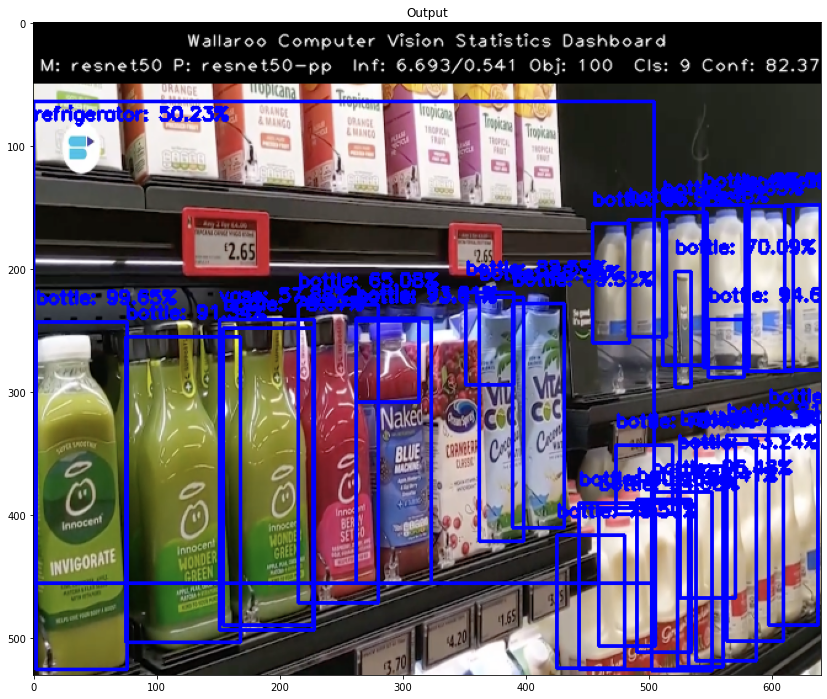

In [16]:

infResults = {
    'model_name' : model_name,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'boxes' : boxes,
    'classes' : classes,
    'confidences' : confidences,
    'confidence-target' : 0.50,
    'inference-time': (endTime-startTime),
    'onnx-time' : int(results['elapsed']) / 1e+9,                
    'color':(255,0,0)
}

cvDemo.drawAndDisplayDetectedObjectsWithClassification(infResults)

In [17]:

pipeline.undeploy()
#for d in wl.list_deployments():
#   d.undeploy()
    

Waiting for undeployment - this will take up to 45s ................................. ok


name,resnet50-pp
created,2022-11-04 13:30:39.844788+00:00
last_updated,2022-12-14 12:57:22.088192+00:00
deployed,False
tags,
steps,mobilenet
